Pierre Navaro - [Institut de Recherche Mathématique de Rennes](https://irmar.univ-rennes1.fr) - [CNRS](http://www.cnrs.fr/)

# References

* [Documentation](https://distributed.readthedocs.io/en/latest/)
* [Dask Tutorial](https://github.com/dask/dask-tutorial)
* [Parallelizing Scientific Python with Dask | SciPy 2017 Tutorial | James Crist](https://youtu.be/mbfsog3e5DA)

# Installation

```bash
pip3 install dask pandas bokeh
```

# Schedulers

By default, Dask computations run using their respective default schedulers on our personal machines.  Often, this default is sufficient, especially when you are bound by NumPy and Pandas routines which release the GIL or when you are using powerful workstation computers with many cores.

However sometimes you may want to execute your code in processes (for Pure Python code that holds onto the GIL), in a single thread (for profiling and debugging) or across a cluster (for larger computations).

### Local Schedulers

Dask separates computation description (task graphs) from execution (schedulers). This allows you to write code once, and run it locally or scale it out across a cluster.

*local* schedulers run only on a single machine with three options:

- `dask.threaded.get         # uses a local thread pool`
- `dask.multiprocessing.get  # uses a local process pool`
- `dask.get                  # uses only the main thread (debugging)`

In [1]:
import dask 
import dask.multiprocessing
import dask.dataframe as dd
import pandas as pd
from glob import glob
import os

In [2]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': object,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

# Maximum non-cancelled delay
largest_delay = df[~df.Cancelled].DepDelay.max()

In [3]:
%time _ = largest_delay.compute()  # this uses threads by default

CPU times: user 11.9 s, sys: 1.43 s, total: 13.3 s
Wall time: 6.77 s


In [4]:
%time _ = largest_delay.compute(get=dask.multiprocessing.get)  # this uses processes

CPU times: user 40.9 s, sys: 11.4 s, total: 52.3 s
Wall time: 1min 3s


In [5]:
%time _ = largest_delay.compute(get=dask.get)  # This uses a single thread

CPU times: user 9.49 s, sys: 1.15 s, total: 10.6 s
Wall time: 10.7 s


# Choosing between Schedulers

- **Threads** can share data back and forth in the same memory space without transfer costs. Threads can pass large arrays between each other instantaneously. 
- **Threads** does not work well when computing on pure Python objects, like strings, lists or custom objects. 
- **Threads** are good when using numeric data and when the computation is complex with many cross-dependencies.
- **Processes** don’t have issues with the GIL, but data transfer between cores when using processes can be expensive. Data transfer isn’t an issue for embarrassingly parallel computations, which is fortunately the norm when dealing with pure Python computations.



# Profiling

``dask.diagnostics`` are useful for seeing bottlenecks in the parallel computation. Use this module only when profiling on a single machine.

In [6]:
from dask.diagnostics import Profiler, ResourceProfiler, visualize
from bokeh.io import output_notebook
output_notebook()

with Profiler() as p, ResourceProfiler(0.25) as r:
    largest_delay.compute()
    
visualize([r, p]);

Loading BokehJS ...

/usr/local/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: ResizeTool is removed in Bokeh 0.12.7, adding it is a no-op. In the future, accessing ResizeTool will be an error
  warn(message)
/usr/local/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: ResizeTool is removed in Bokeh 0.12.7, adding it is a no-op. In the future, accessing ResizeTool will be an error
  warn(message)


# Distributed Scheduler
The dask.distributed system is composed of a single centralized scheduler and several worker processes. 

- [Quickstart](http://distributed.readthedocs.io/en/latest/quickstart.html)
- [Setup Network](http://distributed.readthedocs.io/en/latest/setup.html)

Dask can set up a local cluster for you if you provide no scheduler address to Client:

In [7]:
from dask.distributed import Client

# Setup a local cluster.
# By default this sets up 1 worker per core
client = Client()
client

Client Scheduler: tcp://127.0.0.1:49553 Dashboard: http://127.0.0.1:8787,Cluster Workers: 8 Cores: 8 Memory: 10.31 GB


In [8]:
%time _ = largest_delay.compute(get=client.get)

CPU times: user 235 ms, sys: 80.7 ms, total: 315 ms
Wall time: 3.85 s


# Distributed Cluster

- Store data in the cloud where it can be accessed by all workers.
- Use a networked filesystem that's accessible to all nodes
- Duplicate the files on all nodes

The distributed scheduler is more sophisticated than the single machine schedulers. It comes with more functions to manage data, computing in the background, and more. The distributed scheduler also has entirely separate documentation
- http://distributed.readthedocs.io/en/latest/
- http://distributed.readthedocs.io/en/latest/api.html

# Distributed DataFrames and Efficiency

`dask.dataframe` and `dask.distributed` can be combined on memory large dataset. Remember that Dask uses the blocked algorithm and try to free memory as soon as possible.

## Persist data in distributed memory

Every time we run an operation on a dataframe we read through our dataset from disk.  This can be slow, especially because we're reading data from CSV.  We usually have two options to make this faster:

1.  Persist relevant data in memory, either on our computer or on a cluster
2.  Use a faster on-disk format, like HDF5 or Parquet

You can trigger computations using the persist method:

    x = x.persist()

or the dask.persist function for multiple inputs:

    x, y = dask.persist(x, y)

## Partitions

One `dask.dataframe` is composed of several Pandas dataframes.  The organization of these dataframes can significantly impact performance.  In this section we discuss two common factors that commonly impact performance:

1. The number of Pandas dataframes can affect overhead.  If the dataframes are too small then Dask might spend more time deciding what to do than Pandas spends actually doing it.  Ideally computations should take 100's of milliseconds.

2. If we know how the dataframes are sorted then certain operations become much faster

### Number of partitions and partition size


In [9]:
df.npartitions # Number of partitions

10

In [10]:
df.known_divisions # Are the splits between partitions known?

False

In [11]:
# The splits between partitions. If unknown these are all `None`
df.divisions

(None, None, None, None, None, None, None, None, None, None, None)

- **df data** doesn't have an index.
- if we search for a particular day it takes a while because it has to pass through all of the data.



In [12]:
%time df[df.Date == '1992-05-05'].compute()[:2]

CPU times: user 245 ms, sys: 71.8 ms, total: 316 ms
Wall time: 3.64 s


,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
86090,1992-05-05,2,1048.0,1050,1204.0,1150,US,85,NaN,136.0,...,NaN,14.0,-2.0,EWR,IND,644.0,NaN,NaN,False,0
86119,1992-05-05,2,834.0,835,1039.0,1030,US,87,NaN,125.0,...,NaN,9.0,-1.0,LGA,CLT,544.0,NaN,NaN,False,0


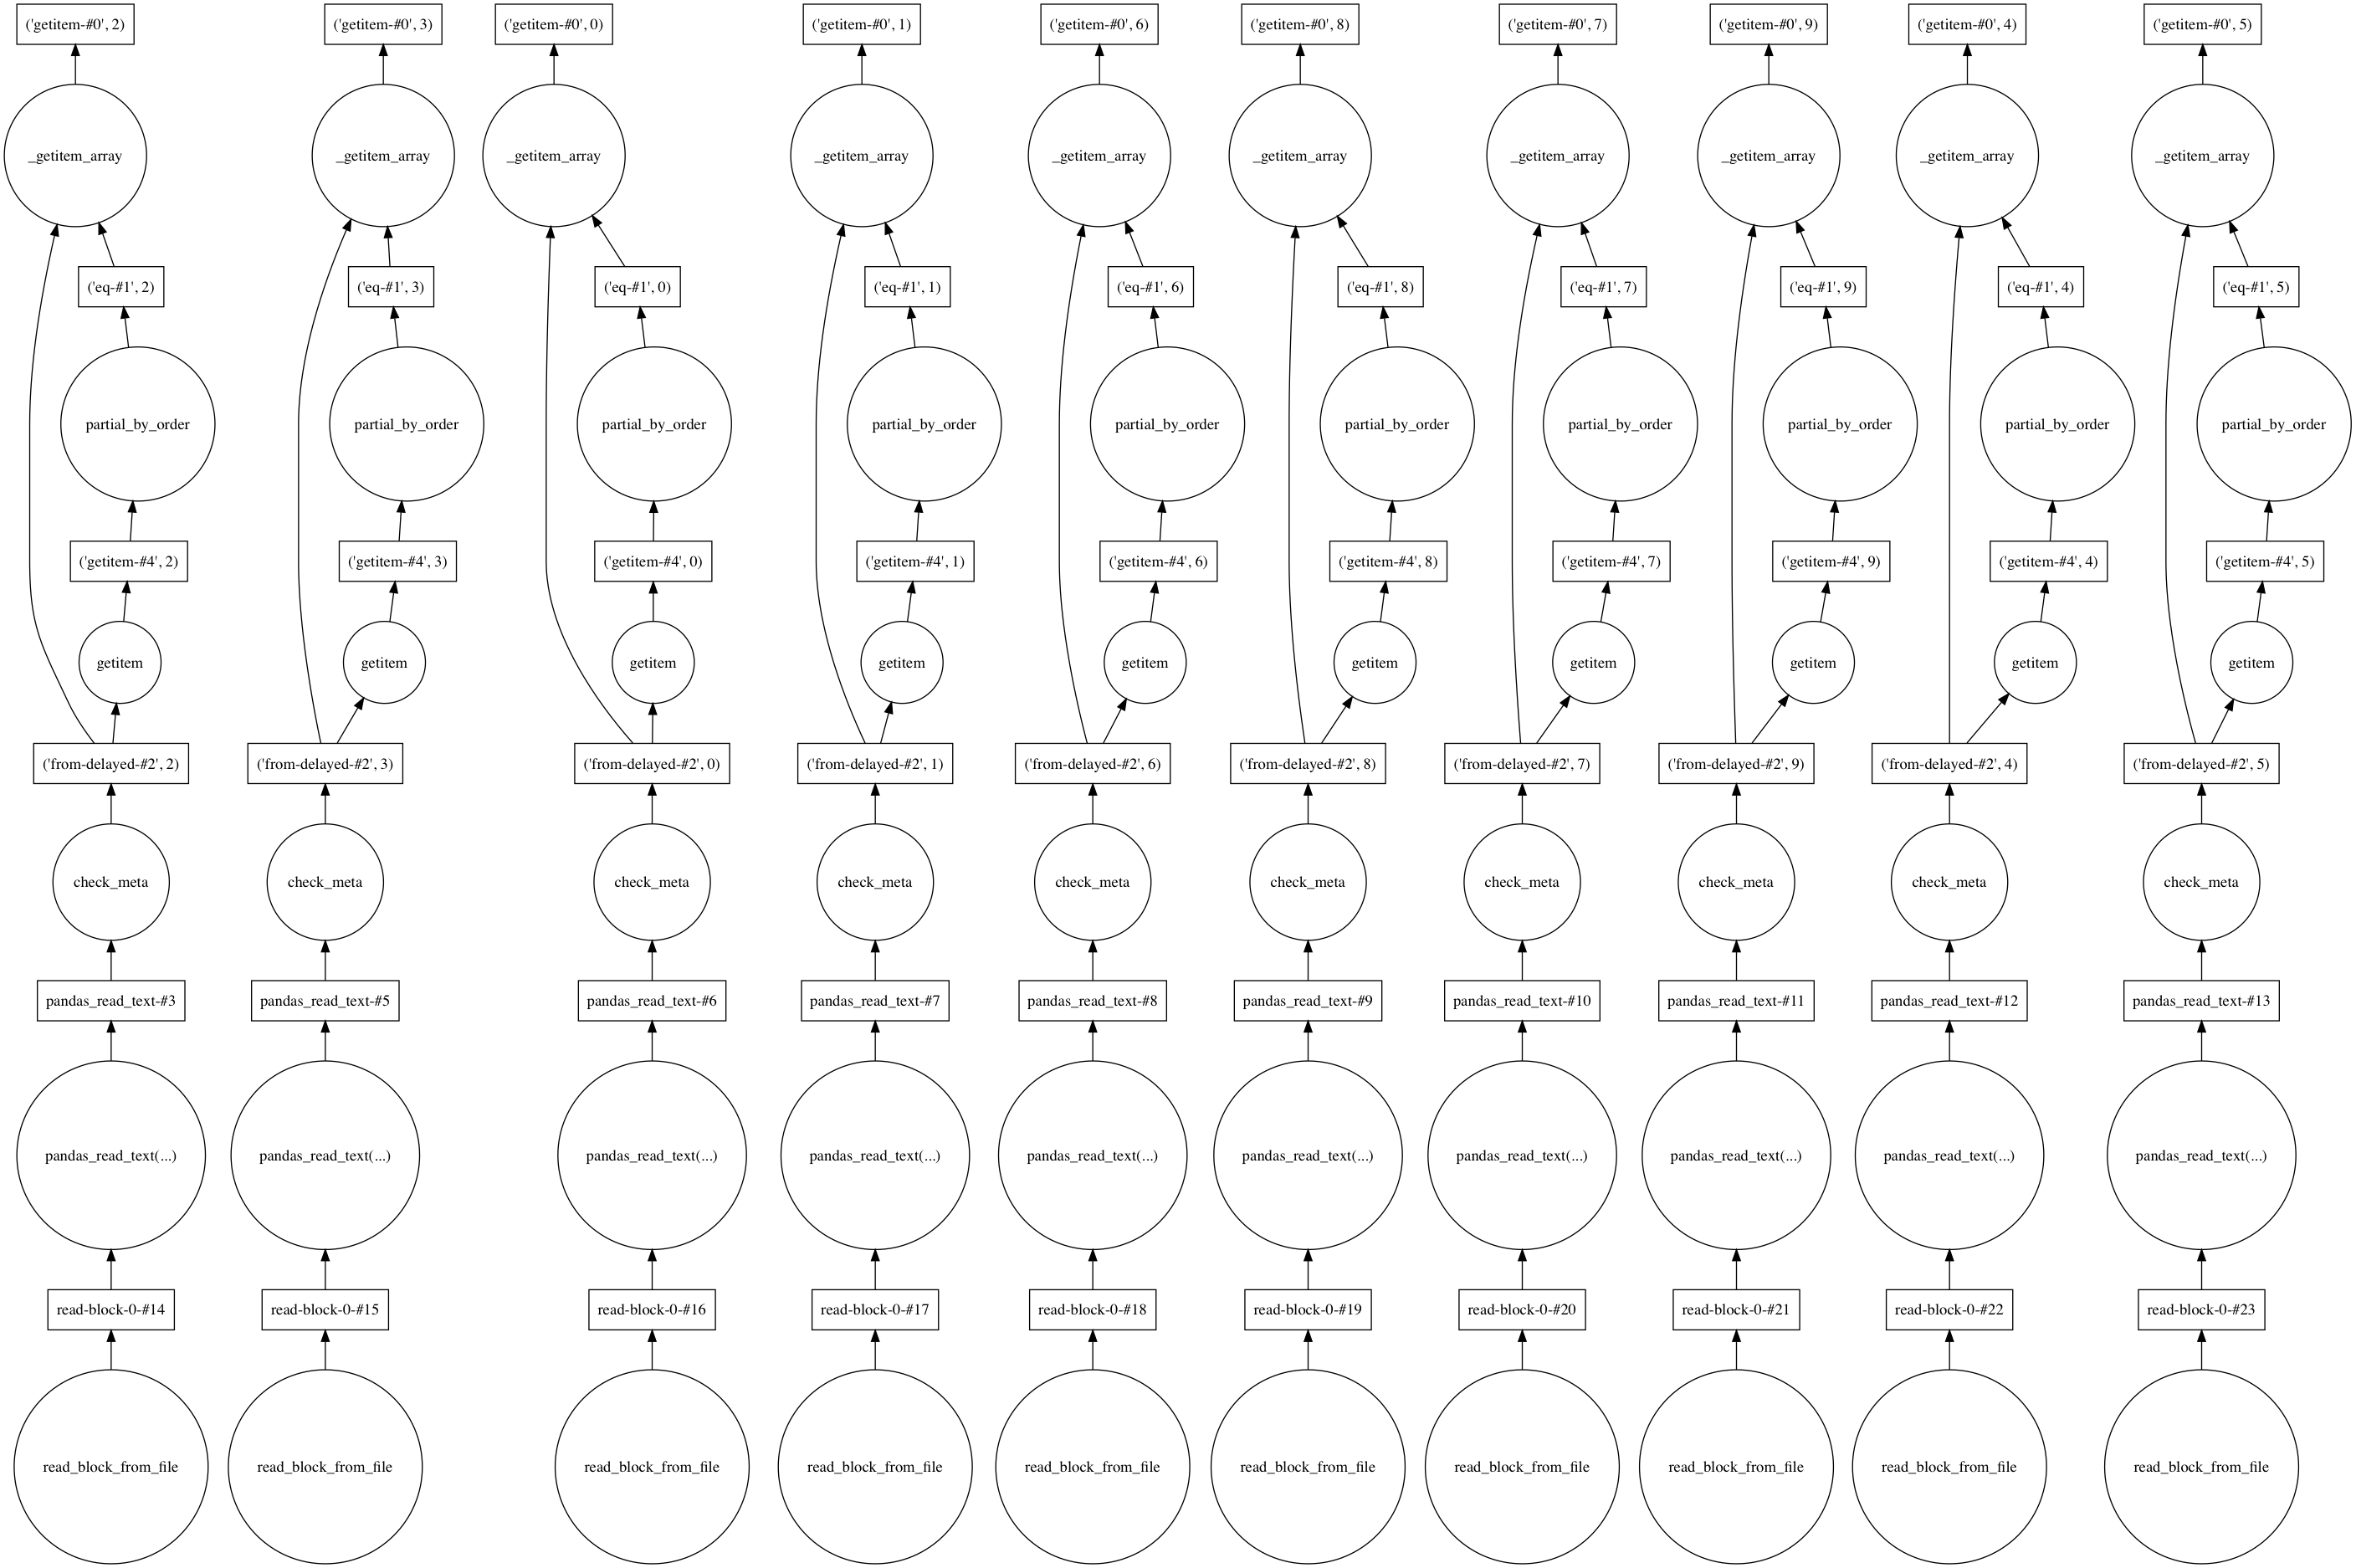

In [13]:
df[df.Date == '1992-05-05'].visualize(optimize_graph=True)

Calling set_index followed by persist results in a new set of dataframe partitions stored in memory, sorted along the index column. To do this dask has to
    * Shuffle the data by date, resulting in the same number of output partitions
    * Set the index for each partition
    * Store the resulting partitions in distributed memory
    
This can be a (relatively) expensive operation, but allows certain queries to be more optimized.

In [14]:
%%time
df = df.set_index('Date').persist()

CPU times: user 255 ms, sys: 68.8 ms, total: 324 ms
Wall time: 3.6 s


In [15]:
df.npartitions # Number of partitions

10

In [16]:
df.known_divisions

True

In [17]:
df.divisions

(Timestamp('1990-01-01 00:00:00'),
 Timestamp('1991-01-01 00:00:00'),
 Timestamp('1992-01-01 00:00:00'),
 Timestamp('1993-01-01 00:00:00'),
 Timestamp('1994-01-01 00:00:00'),
 Timestamp('1995-01-01 00:00:00'),
 Timestamp('1996-01-01 00:00:00'),
 Timestamp('1997-01-01 00:00:00'),
 Timestamp('1998-01-01 00:00:00'),
 Timestamp('1999-01-01 00:00:00'),
 Timestamp('1999-12-31 00:00:00'))

In [18]:
%time df.loc['1992-05-05'].compute()[:2]

CPU times: user 135 ms, sys: 42.6 ms, total: 177 ms
Wall time: 2.21 s


,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
Date,,,,,,,,,,,,,,,,,,,,
1992-05-05,2,1457.0,1500,1616.0,1617,UA,77,NaN,139.0,137.0,NaN,-1.0,-3.0,LGA,ORD,733.0,NaN,NaN,False,0
1992-05-05,2,1902.0,1820,2017.0,1937,US,127,NaN,75.0,77.0,NaN,40.0,42.0,EWR,PIT,319.0,NaN,NaN,False,0


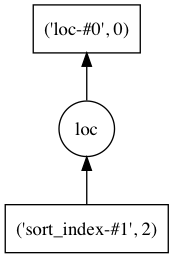

In [19]:
df.loc['1992-05-05'].visualize(optimize_graph=True)

# Distributed futures

The `distributed` scheduler implements a superset of of the standard library `concurrent.futures` api, allowing for asynchronous map-reduce like functionality. We can submit individual functions for evaluation with one set of inputs, or evaluated over a sequence of inputs with `submit()` and `map()`. Notice that the call returns immediately, giving one or more *futures*, whose status begins as "pending" and later becomes "finished". There is no blocking of the local python session.

In [20]:
from dask.distributed import progress, wait

In [21]:
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

### `Client.submit`

`submit` takes a function and arguments and applies them on the cluster, returning a *Future* representing the result to be computed. Note that this cell returns immediately, while computation may still be ongoing on the cluster.

In [22]:
fut = client.submit(inc, 1)
fut

<Future: status: pending, key: inc-5445e8e0aba0c4bf7df7ede671abbe41>

In [23]:
wait(fut); # Block until `fut` has completed

In [24]:
fut.result() # Retrieve the data using `.result()`

2

In [25]:
client.gather(fut) # Retrieve the data using `Client.gather`

2

In [26]:
from dask import delayed

x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)

In [27]:
fut = client.compute(total) # notice the difference from total.compute()
fut # notice that this cell completes immediately

<Future: status: pending, key: finalize-84ea3d55e10b26e8d602fbfd767e1b14>

In [28]:
fut.result()

3

In [29]:
x = client.submit(inc, 1)
y = client.submit(dec, 2)
total = client.submit(add, x, y)

print(total)     # This is still a future
total.result()   # This blocks until the computation has finished

<Future: status: pending, key: add-4a2c9c4eb47520461c0d89b421d9e499>


3

The futures API offers a work submission style that can easily emulate the map/reduce paradigm (see `client.map()`). 
 - Any dask operation that is executed using `.compute()` can be submitted for asynchronous execution using `client.compute()` instead, and this applies to all collections. 
 
Let's call `Client.compute` on a Dask bag.

In [30]:
import dask.bag as db

res = (db.from_sequence(range(10))
         .map(inc)
         .filter(lambda x: x % 2 == 0)
         .sum())
res

In [31]:
f = client.compute(res)
f

<Future: status: pending, key: finalize-a49bcbe4aadb96373a4696d5b3dfd475>

###  Progress Bar

In [32]:
progress(f)

VBox()

In [33]:
client.gather(f)

30

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x13f32a6a8>, <tornado.concurrent.Future object at 0x13724f940>)
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/distributed/comm/core.py", line 185, in connect
    quiet_exceptions=EnvironmentError)
  File "/usr/local/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/usr/local/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, 